In [229]:
import pandas as pd
import numpy as np
import sqlite3
import sys
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

engine = create_engine("sqlite:///courses_2.db")
courses = pd.read_sql('''
SELECT * FROM courses;''', engine)

# courses = courses[courses['satisfaction'] != 100]
courses['teaching'] = courses['teaching_1'] + courses['teaching_2'] + courses['teaching_3'] + courses['teaching_4']
courses['opportunities'] = courses['opportunities_1'] + courses['opportunities_2'] + courses['opportunities_3']
courses['feedback'] = courses['feedback_1'] + courses['feedback_2'] + courses['feedback_3'] + courses['feedback_4']
courses['support'] = courses['support_1'] + courses['support_2'] + courses['support_3']
courses['management'] = courses['management_1'] + courses['management_2'] + courses['management_3']
courses['resources'] = courses['resources_1'] + courses['resources_2'] + courses['resources_3']
courses['community'] = courses['community_1'] + courses['community_2'] 
courses['voice'] = courses['voice_1'] + courses['voice_2'] + courses['voice_3'] + courses['voice_4']


engine = create_engine("sqlite:///hrefs.db")
hrefs = pd.read_sql('''
SELECT * FROM hrefs;''', engine)
engine = create_engine("sqlite:///institutions.db")
institutions = pd.read_sql('''
SELECT * FROM institutions;''', engine)

hrefs['institution'] = hrefs['href'].apply(lambda x: x.split('/')[2])
courses = courses.merge(hrefs.merge(institutions)[['href','longitude','latitude']],how='left')

courses.dropna(subset=['satisfaction','longitude'],inplace=True)



[[
    'teaching_1',
    'teaching_2',
    'teaching_3',
    'teaching_4',
    'opportunities_1',
    'opportunities_2',
    'opportunities_3',
    'feedback_1',
    'feedback_2',
    'feedback_3',
    'feedback_4',
    'support_1',
    'support_2',
    'support_3',
    'management_1',
    'management_2',
    'management_3',
    'resources_1',
    'resources_2',
    'resources_3',
    'community_1',
    'community_2',
    'voice_1',
    'voice_2',
    'voice_3',
    'voice_4',
]]

[['teaching_1',
  'teaching_2',
  'teaching_3',
  'teaching_4',
  'opportunities_1',
  'opportunities_2',
  'opportunities_3',
  'feedback_1',
  'feedback_2',
  'feedback_3',
  'feedback_4',
  'support_1',
  'support_2',
  'support_3',
  'management_1',
  'management_2',
  'management_3',
  'resources_1',
  'resources_2',
  'resources_3',
  'community_1',
  'community_2',
  'voice_1',
  'voice_2',
  'voice_3',
  'voice_4']]

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf 

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


In [231]:
X_train_val, X_test, y_train_val, y_test = train_test_split(courses[[
    'teaching_1',
    'teaching_2',
    'teaching_3',
    'teaching_4',
    'opportunities_1',
    'opportunities_2',
    'opportunities_3',
    'feedback_1',
    'feedback_2',
    'feedback_3',
    'feedback_4',
    'support_1',
    'support_2',
    'support_3',
    'management_1',
    'management_2',
    'management_3',
    'resources_1',
    'resources_2',
    'resources_3',
#     'community_1',
#     'community_2',
    'voice_1',
    'voice_2',
    'voice_3',
    'voice_4',
    'longitude',
    'latitude'
]], courses['satisfaction'], test_size=0.2,random_state=42)

Computing regularization path using the LARS ...


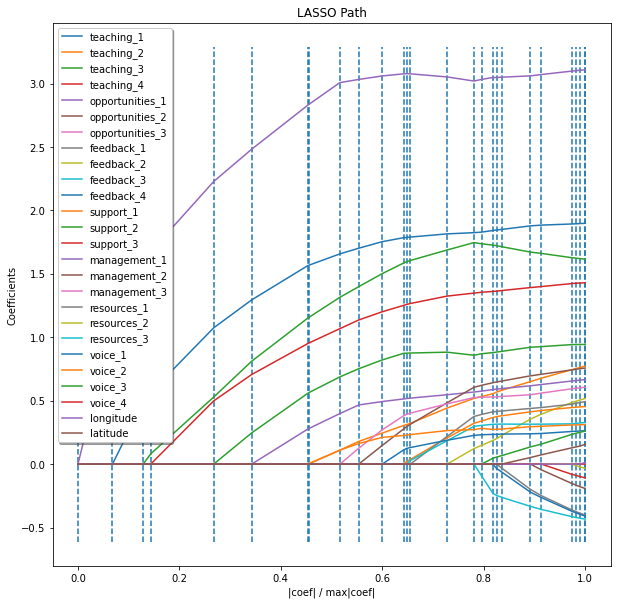

In [232]:

## Scale the variables
std = StandardScaler()
std.fit(X_train_val.values)

X_tr = std.transform(X_train_val.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train_val.values, method='lasso')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train_val.columns, shadow=True)
plt.show()

In [233]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val.values)

StandardScaler()

In [234]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [235]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,400)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.02335205e-02, 1.04724941e-02, 1.07170483e-02,
       1.09673133e-02, 1.12234225e-02, 1.14855124e-02, 1.17537227e-02,
       1.20281961e-02, 1.23090791e-02, 1.25965213e-02, 1.28906759e-02,
       1.31916996e-02, 1.34997528e-02, 1.38149996e-02, 1.41376081e-02,
       1.44677502e-02, 1.48056018e-02, 1.51513429e-02, 1.55051578e-02,
       1.58672350e-02, 1.62377674e-0...
       5.88062599e+01, 6.01795064e+01, 6.15848211e+01, 6.30229527e+01,
       6.44946677e+01, 6.60007502e+01, 6.75420029e+01, 6.91192469e+01,
       7.07333228e+01, 7.23850907e+01, 7.40754307e+01, 7.58052437e+01,
       7.75754513e+01, 7.93869969e+01, 8.12408458e+01, 8.31379858e+01,
       8.50794280e+01, 8.70662068e+01, 8.90993810e+01, 9.11800339e+01,
       9.33092744e+01, 9.54882369e+01, 9.77180827e+01, 1.00000000e+02]),
        cv=5)

In [236]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.01

In [237]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, lasso_model.coef_))

[('teaching_1', 1.895673937714508),
 ('teaching_2', 0.7561532881009755),
 ('teaching_3', 1.6229778737711624),
 ('teaching_4', 1.426856981774161),
 ('opportunities_1', 0.6600807468969937),
 ('opportunities_2', 0.7494397557388961),
 ('opportunities_3', 0.0010450756114229695),
 ('feedback_1', -0.377594879320561),
 ('feedback_2', 0.49845606458689734),
 ('feedback_3', -0.42203792293925024),
 ('feedback_4', -0.3874124433469998),
 ('support_1', 0.44945954918055453),
 ('support_2', 0.9425608541828813),
 ('support_3', 0.0),
 ('management_1', 3.1026934063483895),
 ('management_2', -0.1690797182523537),
 ('management_3', 0.5988869583184019),
 ('resources_1', 0.4807949897588287),
 ('resources_2', -0.014064739786644475),
 ('resources_3', 0.3217903840672328),
 ('voice_1', 0.2594984746397633),
 ('voice_2', 0.30944689390488983),
 ('voice_3', 0.2454526912468338),
 ('voice_4', -0.09137719547750357),
 ('longitude', 0.0),
 ('latitude', 0.13741536732667142)]

In [238]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [239]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.189326130093934

In [240]:
r2_score(y_test, test_set_pred)

0.7434312420338558

# Ridge

In [241]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,400)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([1.00000000e-02, 1.02335205e-02, 1.04724941e-02, 1.07170483e-02,
       1.09673133e-02, 1.12234225e-02, 1.14855124e-02, 1.17537227e-02,
       1.20281961e-02, 1.23090791e-02, 1.25965213e-02, 1.28906759e-02,
       1.31916996e-02, 1.34997528e-02, 1.38149996e-02, 1.41376081e-02,
       1.44677502e-02, 1.48056018e-02, 1.51513429e-02, 1.55051578e-02,
       1.58672350e-02, 1.62377674e-0...
       5.88062599e+01, 6.01795064e+01, 6.15848211e+01, 6.30229527e+01,
       6.44946677e+01, 6.60007502e+01, 6.75420029e+01, 6.91192469e+01,
       7.07333228e+01, 7.23850907e+01, 7.40754307e+01, 7.58052437e+01,
       7.75754513e+01, 7.93869969e+01, 8.12408458e+01, 8.31379858e+01,
       8.50794280e+01, 8.70662068e+01, 8.90993810e+01, 9.11800339e+01,
       9.33092744e+01, 9.54882369e+01, 9.77180827e+01, 1.00000000e+02]),
        cv=5)

In [242]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
ridge_model.alpha_

61.584821106602604

In [243]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('teaching_1', 1.894017485081736),
 ('teaching_2', 0.7727196503489568),
 ('teaching_3', 1.6156061988457238),
 ('teaching_4', 1.4267947908101795),
 ('opportunities_1', 0.6674119856592097),
 ('opportunities_2', 0.7560562141557685),
 ('opportunities_3', 0.007982990935217874),
 ('feedback_1', -0.39870118314784664),
 ('feedback_2', 0.5170663497433683),
 ('feedback_3', -0.43142240758142886),
 ('feedback_4', -0.40870480129704906),
 ('support_1', 0.4543505083047851),
 ('support_2', 0.9413498001859402),
 ('support_3', 0.002885504256074543),
 ('management_1', 3.0954235476249568),
 ('management_2', -0.18917981928775268),
 ('management_3', 0.6118121970748316),
 ('resources_1', 0.49217123255127687),
 ('resources_2', -0.0326442732389857),
 ('resources_3', 0.3286326526290074),
 ('voice_1', 0.26463837707939303),
 ('voice_2', 0.3140917497443486),
 ('voice_3', 0.2596824645984666),
 ('voice_4', -0.10810505753073513),
 ('longitude', 0.012186460467403246),
 ('latitude', 0.1566064319363423)]

In [244]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [245]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.189093197171039

In [246]:
r2_score(y_test, test_set_pred)

0.7434485438891238

/Users/matteofortier/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='satisfaction'>

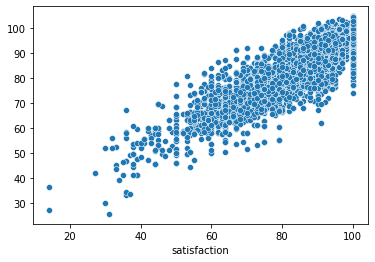

In [247]:
sns.scatterplot(y_test,test_set_pred)